In [1]:
import numpy as np # linear algebra
import os
import random
import shutil
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from IPython.display import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
from textwrap import wrap
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import load_model
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)


/kaggle/input
/kaggle/input/flickr8k
/kaggle/input/flickr8k/Images


## Presentation
https://asjad895.github.io/SE_presentation/

## WEbApp-
https://contentcompanion.streamlit.app/

In [3]:
#reading caption of each image not need for this model 
with open('/kaggle/input/flickr8k/captions.txt') as f:
    lines=f.readlines()
    for l in lines[0:5]:
        print(l)

image,caption

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg,A girl going into a wooden building .

1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .



**INPUT IMAGE ANALYSIS**

(375, 500)


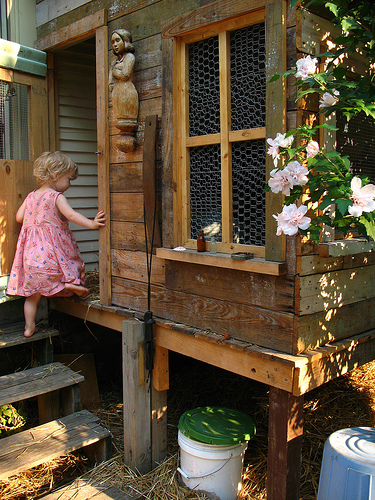

A child in a pink dress is climbing up a set of stairs in an entry way .

A girl going into a wooden building .

A little girl climbing into a wooden playhouse .

A little girl climbing the stairs to her playhouse .

A little girl in a pink dress going into a wooden cabin .



In [4]:
img=Image.open('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg')
print(img.size)
display(img)
with open('/kaggle/input/flickr8k/captions.txt') as f:
    lines=f.readlines()
    for l in lines:
        l=l.split(',')
#         print(l[0])
        if (l[0]=='1000268201_693b08cb0e.jpg'):
            print(l[1])


In [5]:
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

**DATA AUGMENTATION**

In [6]:

# Set minimum crop size
# # Calculate crop box dimensions
# left = (width - min_crop_size) // 2
# top = (height - min_crop_size) // 2
# right = (width + min_crop_size) // 2
# bottom = (height + min_crop_size) // 2


In [7]:
def create_custom_df(min_crop_size=224, num_images=100, data=None):
    # Get the unique image paths and their descriptions
    image_paths_and_desc = data.iloc[:, :2].drop_duplicates(subset='image')
    # Shuffle the image paths and select the first num_images
    selected_images = image_paths_and_desc.sample(n=num_images, random_state=1)
    # Create the output directory if it doesn't exist
    output_dir = 'model_images'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Copy the selected images to the output directory and save their descriptions
    selected_images_with_desc = []
    p=[]
    d=[]
    l=[]
    i=0
    new_rows=[]
    for _, row in selected_images.iterrows():
        image_path = row['image']
        description = row['caption']
        label=i
        p.append(image_path)
        d.append(description)
        l.append(i)
        filename = os.path.basename(image_path)
        src_path = os.path.join('/kaggle/input/flickr8k/Images', image_path)  # Replace with your path to the images
        dst_path = os.path.join(output_dir, filename)
        shutil.copy(src_path, dst_path)
        # Load the image
        img = Image.open(os.path.join(output_dir, os.path.basename(image_path)))
        # Get image dimensions
        width, height = img.size
        # Generate new images by cropping, rotating, etc.
        # Replace this with your own image augmentation code
        for j in range(3):
            # Check if image is smaller than the minimum crop size
            if width < min_crop_size or height < min_crop_size:
                img = img.resize((min_crop_size, min_crop_size))
            crop_transform = transforms.RandomCrop(size=224)
            cropped_img = crop_transform(img)
            # Save the new image to disk
            new_filename = f'{os.path.splitext(os.path.basename(image_path))[0]}_{j}.jpg'
            new_path = os.path.join(output_dir, new_filename)
            cropped_img.save(new_path)
            # Add the new image to the DataFrame
            new_rows.append({'path': new_filename,'caption': description, 'label': label})
            rotation_transform = transforms.RandomRotation(degrees=30)
            rotated_image = rotation_transform(img)
            # Save the new image to disk
            new_filename = f'{os.path.splitext(os.path.basename(image_path))[0]}_{j}_.jpg'
            new_path = os.path.join(output_dir, new_filename)
            rotated_image.save(new_path)
            # Add the new image to the DataFrame
            new_rows.append({'path': new_filename,'caption': description, 'label': label})
        i+=1
    da={'path':p,'caption':d,'label':l}
    df=pd.DataFrame(da)
    df = df.append(new_rows, ignore_index=True)

    # Save the updated DataFrame to the 'train.csv' file
    df.to_csv('train.csv', index=False)
    
    return df



In [8]:
#use this or read directly train.csv as it saved by this function already
df = create_custom_df(min_crop_size=224, num_images=100, data=data)


In [9]:
train=pd.read_csv('/kaggle/working/train.csv')
train.head()

path  \
0   111537217_082a4ba060.jpg   
1   534886684_a6c9f40fa1.jpg   
2  2661138991_d55aa0e5dc.jpg   
3  2560278143_aa5110aa37.jpg   
4  3744832122_2f4febdff6.jpg   

                                             caption  label  
0                         A man climbing a rock wall      0  
1  A man is walking a dog on a leash down the street      1  
2             A GI relaxes and waits at an airport .      2  
3                 A beagle is playing in the grass .      3  
4                 A boy pitches in a baseball game .      4

In [10]:
train.shape,train['label'].nunique()
#we can see there is 100 unique +6*100 created images=700 images
#taking only 100 images due to RAM and GPU availability

((700, 3), 100)

**DATA PREPROCESSING**

In [11]:
# load the CSV file into a pandas dataframe
train_df = pd.read_csv('/kaggle/working/train.csv')
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img


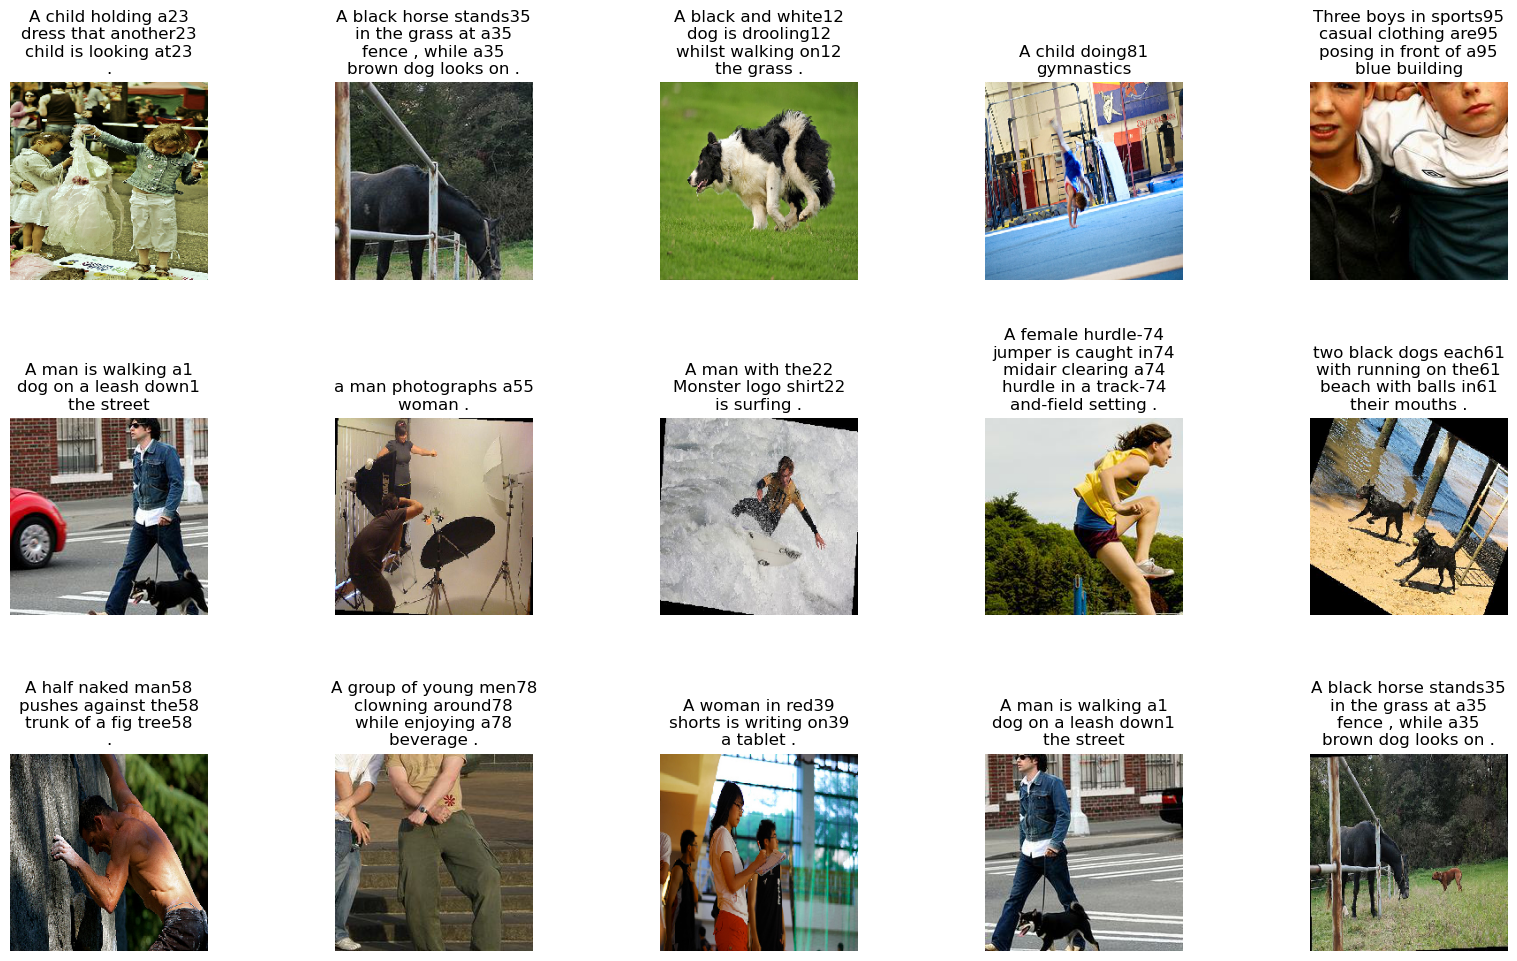

In [12]:
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/kaggle/working/model_images/{temp_df.path[i]}")
        plt.imshow(image)
        a=str(temp_df.label[i])+"\n"
        plt.title(a.join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")
display_images(train.sample(15))

**IMAGE PREPROCESSING**

In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def Create_X_y(csv_path, img_size=224):
    # Read in the CSV file
    data = pd.read_csv(csv_path)
    # Get the image paths and labels
    dirs='/kaggle/working/model_images/'
    image_paths = data['path'].tolist()
    labels = data['label'].tolist()
    # Initialize empty arrays to hold the preprocessed image data and labels
    num_samples = len((image_paths))
    X = np.zeros((num_samples, img_size, img_size, 3))
    y = np.array(labels)

    # Loop over the image paths and load in the images
    for i, image_path in enumerate(image_paths):
        # Load in the image
        path = os.path.join(dirs, image_path)
        img = readImage(path,img_size=img_size)
        # Add the preprocessed image and label to the arrays
        X[i] = img

    return X, y


**SPLIT DATASET INTO TRAIN TEST**

In [14]:
X, y = Create_X_y('train.csv', img_size=224)
# Shuffle the data so that we will get random shuffle image for training,that will be better for training
X, y = shuffle(X, y, random_state=1)

In [15]:
X.shape,y.shape

((700, 224, 224, 3), (700,))

In [16]:
# Split X and y into train and test sets into 80:20 for training:testing ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Print the shapes of the resulting train and test sets
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (560, 224, 224, 3)
y_train shape: (560,)
X_test shape: (140, 224, 224, 3)
y_test shape: (140,)


**POSITIVE AND NEGATIVE IMAGE PAIR**

In [17]:
def make_pairs(images, labels):
    pairImages = []
    pairLabels = []
    nc = len(np.unique(labels))
    print("total no of unique images:",nc)
    idx = np.concatenate([np.where(labels == i)[0] for i in range(nc)])
    print("total training/testing images:",len(idx))
    for o in range(len(images)):
        currentimage = images[o]
        label = labels[o]
        # Get a boolean array indicating which elements in label are equal to i
        mask = (labels == label)

# Get the indices of the images corresponding to class i
        idx = np.where(mask)[0]

# Randomly select an index from idx
        rimg = np.random.choice(idx)
        posImage = images[rimg]
        pairImages.append([currentimage, posImage])
        pairLabels.append([1])
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        pairImages.append([currentimage, negImage])
        pairLabels.append([0])
    return (np.array(pairImages), np.array(pairLabels))

In [18]:
# prepare the positive and negative pairs for training data
print("**preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(X_train, y_train)

**preparing positive and negative pairs...
total no of unique images: 100
total training/testing images: 560


In [19]:
# prepare the positive and negative pairs for testing data
(pairTest, labelTest) = make_pairs(X_test, y_test)

total no of unique images: 79
total training/testing images: 117


In [20]:
pairTrain.shape,labelTrain.shape

((1120, 2, 224, 224, 3), (1120, 1))

**MODEL BUILDING**

**BUILDING SIAMESE NETWORK**

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda

In [22]:
def Siamese(inputShape, embeddingDim=300):
    inputs = Input(inputShape)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs)
    return model

**CONTRASTIVE LOSS**

In [23]:
import tensorflow.keras.backend as K
import tensorflow as tf
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    return loss

In [24]:
#for finding similarity between 2 image's vectors(in high demensional space)
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [25]:
def construct_siamese_network():
    print("*********Building Siamese Network************)")
    imgA = Input(shape=(224, 224, 3))
    imgB = Input(shape=(224, 224, 3))
    featureExtractor = Siamese(inputShape=(224, 224, 3))
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)

# finally, construct the siamese network
    distance = Lambda(euclidean_distance)([featsA, featsB])
    model = Model(inputs=[imgA, imgB], outputs=distance)
    print("Siamese Network Constructed!")
    return model
    

In [26]:
model=construct_siamese_network()

*********Building Siamese Network************)
Siamese Network Constructed!


**TRAINING**

In [27]:
from keras.callbacks import EarlyStopping

In [28]:
def Train():
    # compile the model
    print("Compiling Model:...")
#using Adam optimizer for gradient as it is best performing
    model.compile(loss=contrastive_loss, optimizer="adam")
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# train the model
    print("Training Model:...")
    history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
                    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
                    batch_size=32,epochs=50,callbacks=[early_stopping])
    return history

In [29]:
history=Train()

Compiling Model:...
Training Model:...
Epoch 1/50


2023-05-05 13:18:28.254292: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


35/35 [==============================] - 22s 333ms/step - loss: 0.1253 - val_loss: 0.0859
Epoch 2/50
35/35 [==============================] - 10s 285ms/step - loss: 0.0903 - val_loss: 0.0973
Epoch 3/50
35/35 [==============================] - 10s 287ms/step - loss: 0.0822 - val_loss: 0.0755
Epoch 4/50
35/35 [==============================] - 10s 288ms/step - loss: 0.0788 - val_loss: 0.0830
Epoch 5/50
35/35 [==============================] - 10s 289ms/step - loss: 0.0695 - val_loss: 0.0781
Epoch 6/50
35/35 [==============================] - 10s 297ms/step - loss: 0.0661 - val_loss: 0.0594
Epoch 7/50
35/35 [==============================] - 10s 291ms/step - loss: 0.0641 - val_loss: 0.0705
Epoch 8/50
35/35 [==============================] - 10s 299ms/step - loss: 0.0603 - val_loss: 0.0543
Epoch 9/50
35/35 [==============================] - 10s 291ms/step - loss: 0.0609 - val_loss: 0.0676
Epoch 10/50
35/35 [==============================] - 11s 301ms/step - loss: 0.0624 - val_loss: 0.0599


**LOSS ANALYSIS**

In [30]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


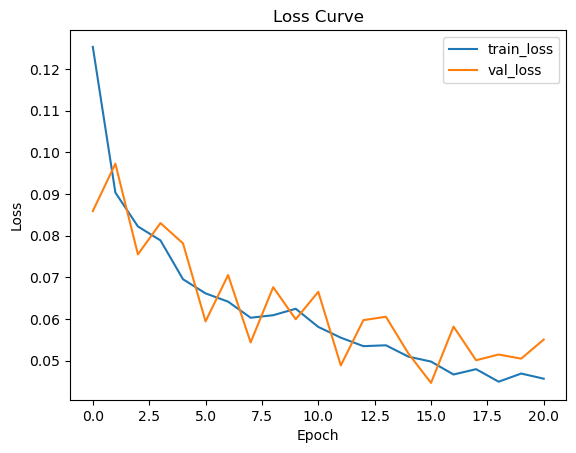

In [31]:
def loss():
    # plot loss curve
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_curve.png')
loss()

In [32]:
import joblib 
joblib.dump(model, 'ContentCompanion_model.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......functional
.........layers
............conv2d
...............vars
..................0
..................1
............conv2d_1
...............vars
..................0
..................1
............conv2d_2
...............vars
..................0
..................1
............dense
...............vars
..................0
..................1
............dropout
...............vars
............dropout_1
...............vars
............dropout_2
...............vars
............global_average_pooling2d
...............vars
............input_layer
...............vars
............max_pooling2d
...............vars
............max_pooling2d_1
...............vars
............max_pooling2d_2
...............vars
.........vars
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0

['ContentCompanion_model.pkl']

**TEST**

In [33]:
# evaluate the model on the test dataset
test_loss = model.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:], batch_size=32)
print('Test loss:', test_loss)

9/9 [==============================] - 0s 37ms/step - loss: 0.0550
Test loss: 0.055029671639204025


In [34]:
model.save('siamese_model.h5')
# load the saved model
model = load_model('siamese_model.h5',custom_objects={'contrastive_loss': contrastive_loss})
embedding_model = model.layers[2]
embedding_model = Model(inputs=embedding_model.input, outputs=embedding_model.layers[-2].output)


**EMBEDDING NETWORK**

In [56]:
def Create_Embedding():
    # Compute the embeddings of all the retrieval set images and save them to disk
    embeddings = []
    filenames = []
    for img_file in train['path']:
        img_file=os.path.join('/kaggle/working/model_images/',img_file)
        img = readImage(path=img_file)
        emb = embedding_model.predict(np.expand_dims(img, axis=0))[0]
        embeddings.append(emb)
        filenames.append(img_file)
        np.savez("retrieval_set_embeddings.npz", embeddings=embeddings, filenames=filenames)
    print("""Saving Embedding Network of all the Trained Images,
        which is used at the time of Testing or Query on unseen Images""")

In [57]:
Create_Embedding()

1/1 [==============================] - 0s 19ms/step
Saving Embedding Network of all the Trained Images,
        which is used at the time of Testing or Query on unseen Images


In [58]:
t=pd.read_csv('/kaggle/working/train.csv')
t.head()

path  \
0   111537217_082a4ba060.jpg   
1   534886684_a6c9f40fa1.jpg   
2  2661138991_d55aa0e5dc.jpg   
3  2560278143_aa5110aa37.jpg   
4  3744832122_2f4febdff6.jpg   

                                             caption  label  
0                         A man climbing a rock wall      0  
1  A man is walking a dog on a leash down the street      1  
2             A GI relaxes and waits at an airport .      2  
3                 A beagle is playing in the grass .      3  
4                 A boy pitches in a baseball game .      4

In [59]:
# compute the euclidean distance between two vectors a and b
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

In [60]:
# Compute the embedding of a query (attributes vector)
path=os.path.join('/kaggle/working/model_images/','2560278143_aa5110aa37.jpg')
query_img = readImage(path=path)
query_emb = embedding_model.predict(np.expand_dims(query_img, axis=0))[0]

# Compute the distances between the query embedding and all the retrieval set embeddings
retrieval_set_embeddings = np.load("retrieval_set_embeddings.npz")
retrieval_set_embs = retrieval_set_embeddings["embeddings"]
retrieval_set_filenames = retrieval_set_embeddings["filenames"]
distances = [euclidean_distance(query_emb, emb) for emb in retrieval_set_embs]
sorted_indexes = np.argsort(distances)

# Get the closest ones
k = 10
closest_filenames = retrieval_set_filenames[sorted_indexes][:k]

1/1 [==============================] - 0s 21ms/step


In [61]:
print(closest_filenames)

['/kaggle/working/model_images/2560278143_aa5110aa37.jpg'
 '/kaggle/working/model_images/2560278143_aa5110aa37_1.jpg'
 '/kaggle/working/model_images/2560278143_aa5110aa37_2_.jpg'
 '/kaggle/working/model_images/2560278143_aa5110aa37_2.jpg'
 '/kaggle/working/model_images/2560278143_aa5110aa37_1_.jpg'
 '/kaggle/working/model_images/2560278143_aa5110aa37_0_.jpg'
 '/kaggle/working/model_images/2560278143_aa5110aa37_0.jpg'
 '/kaggle/working/model_images/503717911_fc43cb3cf9_0.jpg'
 '/kaggle/working/model_images/503717911_fc43cb3cf9.jpg'
 '/kaggle/working/model_images/503717911_fc43cb3cf9_0_.jpg']


**QUERY ON UNSEEN DATA**

In [62]:
def retrived(query):
    # get the indices that would sort the distances array in ascending order
    path=os.path.join(query)
    query_img = readImage(path=path)
    query_emb = embedding_model.predict(np.expand_dims(query_img, axis=0))[0]

# Compute the distances between the query embedding and all the retrieval set embeddings
    retrieval_set_embeddings = np.load("retrieval_set_embeddings.npz")
    retrieval_set_embs = retrieval_set_embeddings["embeddings"]
    retrieval_set_filenames = retrieval_set_embeddings["filenames"]
    distances = [euclidean_distance(query_emb, emb) for emb in retrieval_set_embs]
    sorted_indexes = np.argsort(distances)

# print the top-k images with their corresponding distances
    k = 10
    d=[]
    img=[]
    cap=[]
    for i in range(k):
        image_index = sorted_indexes[i]
        image_path=retrieval_set_filenames[image_index]
        p=image_path.split('model_images/')[1]
        # filter the rows containing the path
        filtered_df = train[train["path"] == p]

# get the indices of the filtered rows
        indices = filtered_df.index.tolist()
        cap.append(indices)
        image_distance = distances[image_index]
        d.append(image_distance)
        img.append(image_path)
        print(f"Image {i+1}: {image_path} - Distance: {image_distance}-caption:{indices}")
    return d,img,cap
        

**query result**

In [63]:
def show_retrieved_images(query, retrieved_images, distances, k):
    fig, axs = plt.subplots(2, 6, figsize=(20, 10))
    img = load_img(query, color_mode='rgb', target_size=(224, 224))
    img= img_to_array(img)
    query_img = img / 255.0
    axs[0,0].imshow(query_img)
    axs[0,0].set_title("Query Image")
    for i in range(5):
        img = load_img(retrieved_images[i], color_mode='rgb', target_size=(224, 224))
        img= img_to_array(img)
        img = img / 255.0
        axs[0,i+1].imshow(img)
        axs[0,i+1].set_title(f"Distance: {distances[i]:.2f}")
    for i in range(5, 10):
        img = load_img(retrieved_images[i], color_mode='rgb', target_size=(224, 224))
        img= img_to_array(img)
        img = img / 255.0
        axs[1,i-4].imshow(img)
        axs[1,i-4].set_title(f"Distance: {distances[i]:.2f}")
    plt.show()


In [64]:
d,rt,cap=retrived('/kaggle/working/model_images/2560278143_aa5110aa37.jpg')

1/1 [==============================] - 0s 22ms/step
Image 1: /kaggle/working/model_images/2560278143_aa5110aa37.jpg - Distance: 0.0-caption:[3]
Image 2: /kaggle/working/model_images/2560278143_aa5110aa37_1.jpg - Distance: 0.05272702872753143-caption:[120]
Image 3: /kaggle/working/model_images/2560278143_aa5110aa37_2_.jpg - Distance: 0.08083391934633255-caption:[123]
Image 4: /kaggle/working/model_images/2560278143_aa5110aa37_2.jpg - Distance: 0.10956001281738281-caption:[122]
Image 5: /kaggle/working/model_images/2560278143_aa5110aa37_1_.jpg - Distance: 0.14082252979278564-caption:[121]
Image 6: /kaggle/working/model_images/2560278143_aa5110aa37_0_.jpg - Distance: 0.14951254427433014-caption:[119]
Image 7: /kaggle/working/model_images/2560278143_aa5110aa37_0.jpg - Distance: 0.23120422661304474-caption:[118]
Image 8: /kaggle/working/model_images/503717911_fc43cb3cf9_0.jpg - Distance: 0.25961393117904663-caption:[634]
Image 9: /kaggle/working/model_images/503717911_fc43cb3cf9.jpg - Dista

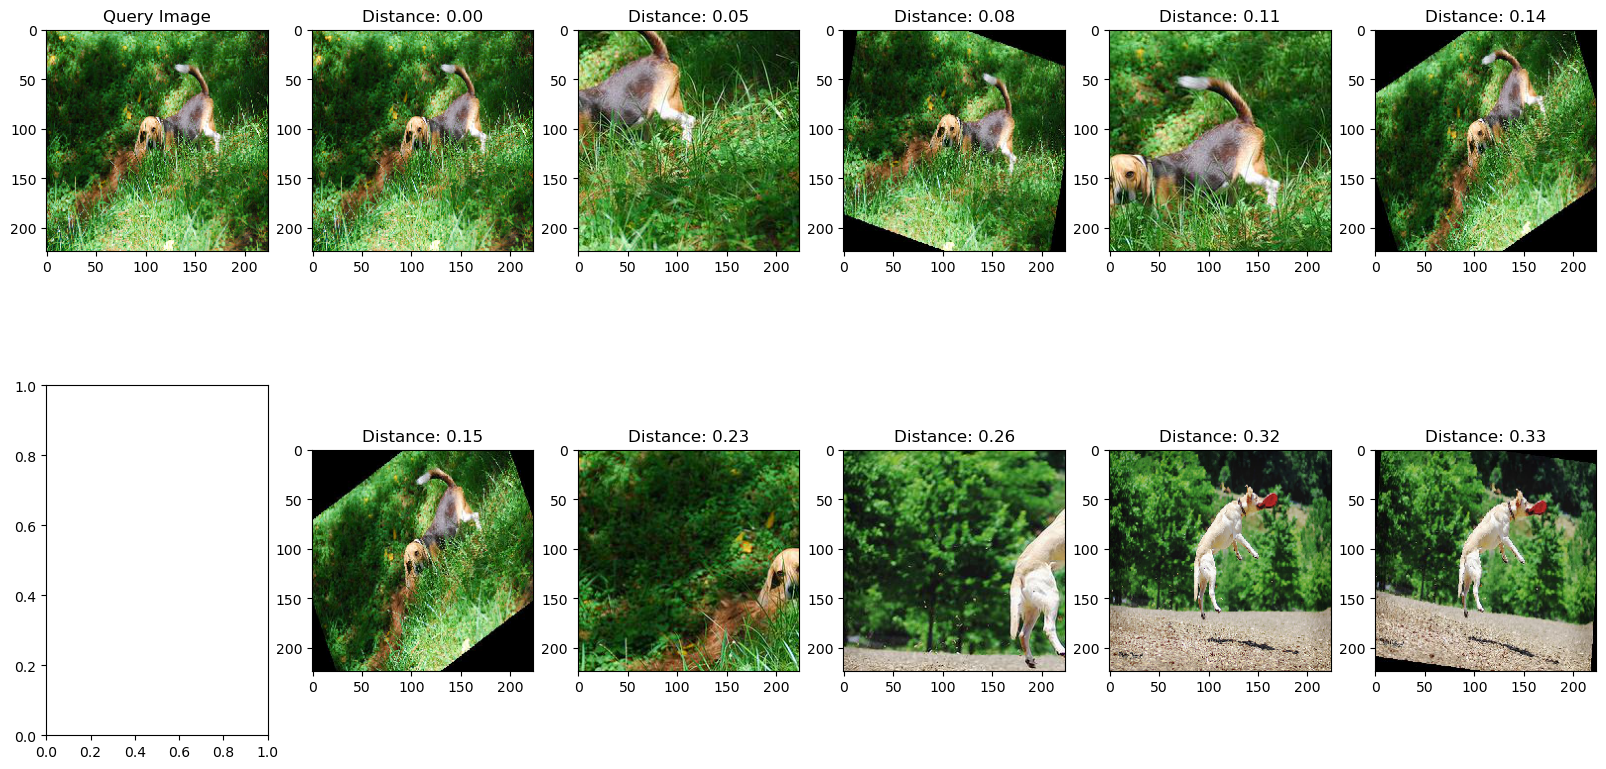

In [65]:
show_retrieved_images('/kaggle/working/model_images/2560278143_aa5110aa37.jpg', rt, d, k=10)

In [66]:
d,rt,cap=retrived('/kaggle/working/model_images/2661138991_d55aa0e5dc.jpg')

1/1 [==============================] - 0s 29ms/step
Image 1: /kaggle/working/model_images/2661138991_d55aa0e5dc.jpg - Distance: 0.0-caption:[2]
Image 2: /kaggle/working/model_images/2661138991_d55aa0e5dc_0_.jpg - Distance: 0.015008758753538132-caption:[113]
Image 3: /kaggle/working/model_images/2661138991_d55aa0e5dc_2_.jpg - Distance: 0.027920560911297798-caption:[117]
Image 4: /kaggle/working/model_images/2661138991_d55aa0e5dc_1_.jpg - Distance: 0.0645461156964302-caption:[115]
Image 5: /kaggle/working/model_images/2661138991_d55aa0e5dc_2.jpg - Distance: 0.12503696978092194-caption:[116]
Image 6: /kaggle/working/model_images/2661138991_d55aa0e5dc_1.jpg - Distance: 0.17143498361110687-caption:[114]
Image 7: /kaggle/working/model_images/3387661249_33e5ba0bc5_2.jpg - Distance: 0.17728888988494873-caption:[314]
Image 8: /kaggle/working/model_images/2661138991_d55aa0e5dc_0.jpg - Distance: 0.1822713315486908-caption:[112]
Image 9: /kaggle/working/model_images/2838619742_eed855d8a8_0.jpg - D

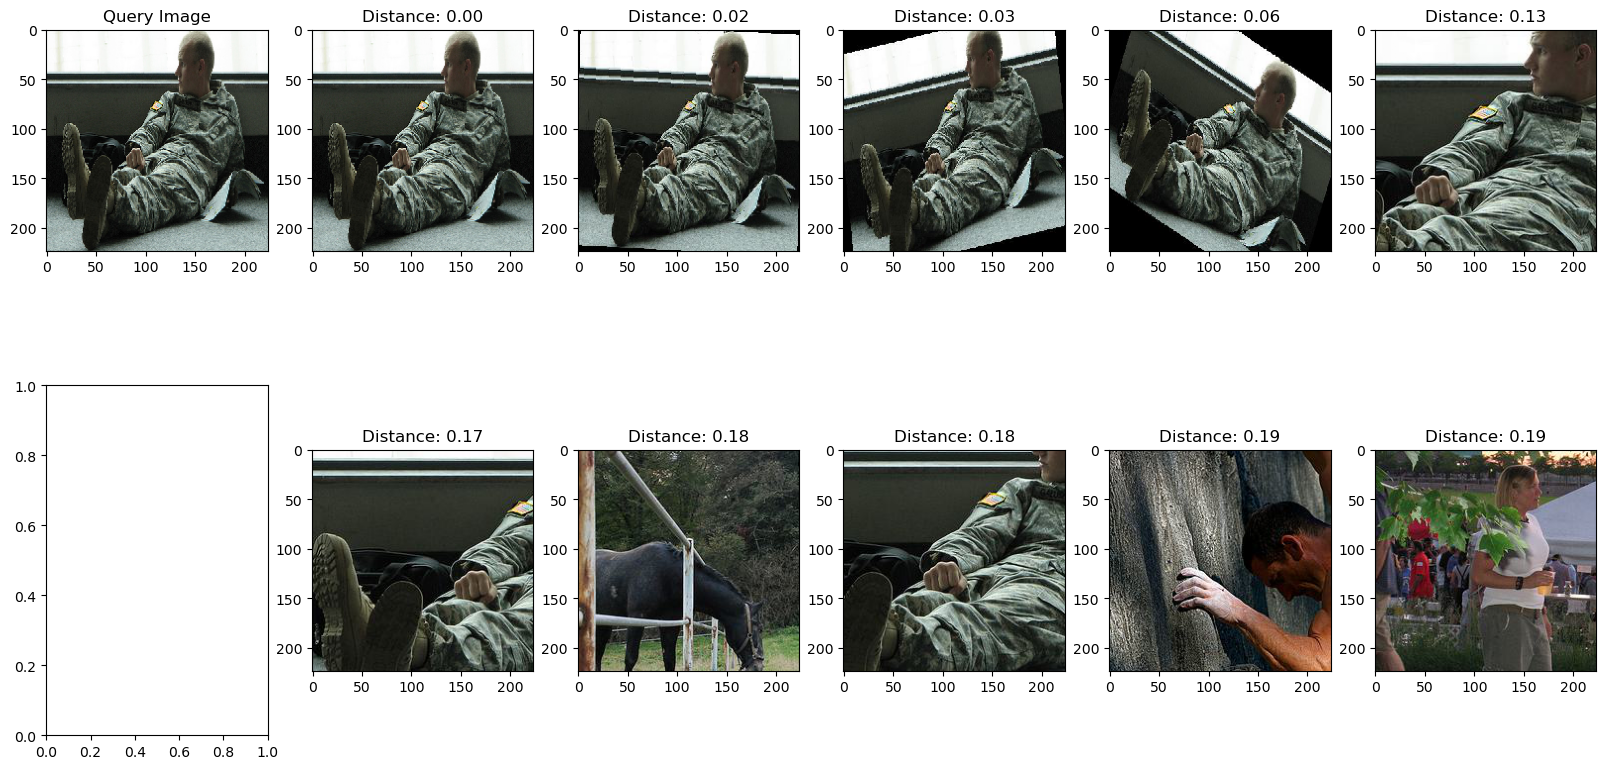

In [67]:
show_retrieved_images('/kaggle/working/model_images/2661138991_d55aa0e5dc.jpg', rt, d, k=10)

In [68]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found


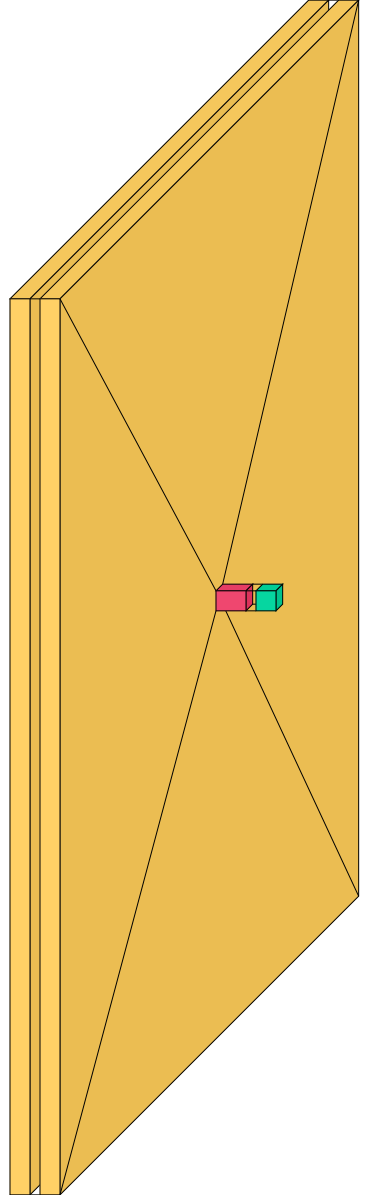

/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmplilf0zqz.PNG'


In [69]:
import visualkeras
visualkeras.layered_view(model,scale_xy=0.5, to_file='model.png').show() # write and show

visualkeras.layered_view(model)

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmpteoe4ldk.PNG'


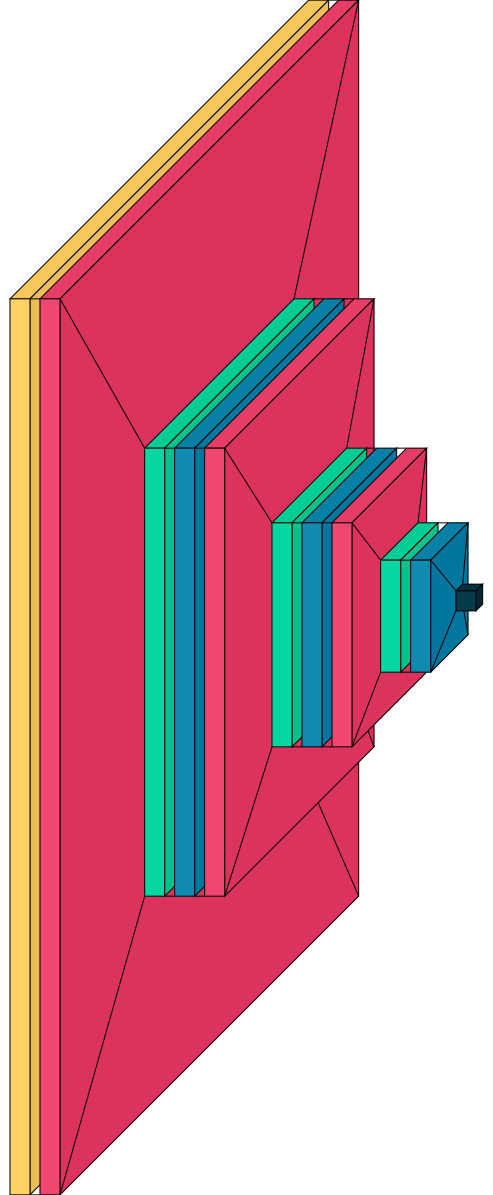

In [70]:
em=embedding_model
visualkeras.layered_view(em,scale_xy=0.5, to_file='embedding_model.png').show() # write and show
visualkeras.layered_view(em)

In [71]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 300)          73708       ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [72]:
embedding_model.save('embedding_model.h5')

In [73]:
embedding_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                       

In [74]:
joblib.dump(embedding_model, 'embedding_model.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......global_average_pooling2d
.........vars
......input_layer
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-05 13:25:27         4071
variables.h5                                   2023-05-05 13:25:27       243304
metadata.json                                  2023-05-05 13:25:27           64


['embedding_model.pkl']

In [75]:
shutil.make_archive('images', 'zip','/kaggle/working/model_images')

'/kaggle/working/images.zip'

In [76]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/images.zip')


/kaggle/working/images.zip